# Loan Application Study

## Table of Contents
- [Introduction](#intro)
- [Data Wrangling](#wrangling)
- [Exploratory Data Analysis](#eda)
- [Conclusion of Analysis](#conclusions)
- [Modeling](#modeling)



<a id='introduction'></a>
## Introduction

#### Explanation of the MOS Transistor Behavior (n-channel)

The behavior of an n-channel MOS transistor can be explained as follows:

* When the gate current (Ig) is zero, the drain current (Id), equal to the source current (Is), represents the total current passing through the entire transistor.

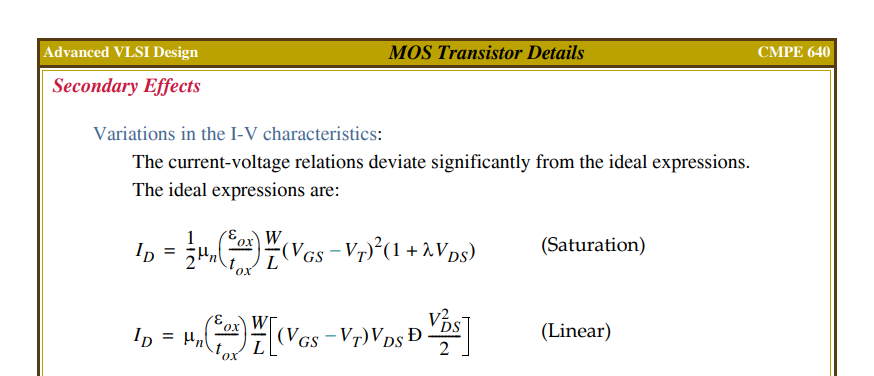

* The value of Id depends on the operating region of the transistor, which is determined by\
the voltages Vgs (gate-source voltage) and Vds (drain-source voltage).
* There are three main regions:


    1. **Cut Off**:
       - If Vgs < Vth (threshold voltage), the transistor is in the "Cut Off" state.
       - Id = 0.

    2. **Triode (Linear)**:
       - If Vgs >= Vth, the transistor turns "ON."
       - In this region, when Vds < Vgs - Vth, the transistor operates in the "Triode" state.
       - Id follows the Linear Law in the image above ☝🏻

    3. **Saturation (Amplifier)**:
       - When Vds > Vgs - Vth in the "ON" state, the transistor is in "Saturation" acting as an **amplifier**.
       - Id follows the Saturation Law in the image above ☝🏻
       
---

### The Challenge 💡
In the complex world of semiconductor physics, predicting transistor current (Id) typically demands numerous features. Our challenge? To harness the power of simplicity. We aim to predict Id using just the following features:

* **vds**: Drain-Source Voltage
* **L(um)**: Length of the transistor (in micrometers)
* **W(um)**: Width of the transistor (in micrometers)
* **drain_length(um)**: Drain length (in micrometers)
* **temperature**: Temperature (in Celsius)
* **vgs**: Gate-Source Voltage
* **vsb**: Source-Body Voltage
    * Vsb can affect the threshold voltage (Vth) and other characteristics.
* **corner**: Categorical corner information
    *  Are used to model the worst-case scenarios of device performance, considering factors like voltage, temperature, and manufacturing process variations.

### Imports & Configrations

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import StrMethodFormatter

import seaborn as sns
sns.set()


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 150)
SEED = 1234

df = pd.read_csv('../Data/simulated_data_nmos.csv')

df.head(2)

,vds,L(um),W(um),drain_length(um),temperature,vgs,vsb,vth,v_pinch_off,lambda(um),id(uA),ig(aA),gm(uS),gmb(uS),ro(Kohm),cgg(aF),cgs(aF),cgd(aF),cdd(aF),cdb(aF),cgb(aF),csb(aF),corner
0,-0.45,8.0,0.84,0.3,27.0,0.0,0.0,0.402306,-0.45,-0.011819,0.034866,0.0,0.659740,0.197561,3181189.42,34032.2445,-28204.1822,-69.122702,88.099279,-4468.20789,-5758.93958,-6638.15046,tt
1,-0.40,8.0,0.84,0.3,27.0,0.0,0.0,0.420865,-0.45,-0.011819,0.009451,0.0,0.196701,0.060563,6552405.05,31291.9536,-24561.0933,-64.892149,80.854021,-3789.70803,-6665.96815,-5628.27847,tt


> Considering only the required features.

In [25]:
df = df[['vds', 'vgs', 'vsb','L(um)', 'W(um)', 'drain_length(um)', 'temperature', 'corner', 'id(uA)']]
df.head(2)

,vds,vgs,vsb,L(um),W(um),drain_length(um),temperature,corner,id(uA)
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


> Changing the columns names to more easy names

In [36]:
df.rename(columns={
    'L(um)': 'l',
    'W(um)': 'w',
    'drain_length(um)': 'drain_len',
    'id(uA)': 'id'}, inplace=True)
df.head(2)

,vds,vgs,vsb,l,w,drain_len,temperature,corner,id
0,-0.45,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.034866
1,-0.40,0.0,0.0,8.0,0.84,0.3,27.0,tt,0.009451


### Functions we will use

In [326]:
def add_compination_of_features(data):
    """
    Applying some feature engineering on the data to add 
    some compination of origin features
    
    Parameters:
    data (pd.DataFrame): The input DataFrame containing only origin features

    Returns:
    pd.DataFrame: The modified DataFrame with added features
    """
    
    data['w/l'] = data['w'] / data['l']
    data['vgs-vds'] = data['vgs'] - data['vds']
    data['vgs*vds'] = data['vgs'] * data['vds']
    data['vds_squared'] = data['vds'] ** 2
    
    return data

def mean_id_by_column(data, columns, x_rotation=0):
    """
    Visualizes the relationship between specified columns and the average 'id' (transistor current) values.

    Parameters:
        - data (DataFrame): The DataFrame containing the data to be analyzed.
        - columns (list): A list of column names to be analyzed.

    Returns:
        None

    This function groups the data by unique values in the specified columns, calculates the mean 'id' values for each group,
    and creates point plots to compare the relationships between the columns and the average 'id' values in separate subplots.

    Example Usage:
    mean_id_by_column(df_train, ['vgs', 'w', 'l'])
    """
    num_columns = len(columns)
    fig, axes = plt.subplots(num_columns, 1, figsize=(10, 3*num_columns))
    
    
    for i, col in enumerate(columns):
        # Grouping the Id by the unique values of each column
        mean_id_by_column = df_train.groupby(col).mean().id.reset_index()
        
        if col == 'vds':
            '''rounding the vds axis labels to .2f as there is a value
            near to zero but not plotted as zero.'''
            mean_id_by_column[col] = mean_id_by_column[col].round(2)
        
        ax = axes[i]
        
        # Create a point plot to compare mean 'id' values
        sns.pointplot(data=mean_id_by_column, x=col, y='id', label=col, ax=ax)
        ax.set_title(f'Average current per {col}')
        ax.set_ylabel('Average current passes (uA)')
        ax.tick_params(axis='x', rotation=x_rotation)
        

    plt.tight_layout()

## Data Wrangling

### Data Assessing

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871488 entries, 0 to 871487
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   vds          871488 non-null  float64
 1   vgs          871488 non-null  float64
 2   vsb          871488 non-null  float64
 3   l            871488 non-null  float64
 4   w            871488 non-null  float64
 5   drain_len    871488 non-null  float64
 6   temperature  871488 non-null  float64
 7   corner       871488 non-null  object 
 8   id           871488 non-null  float64
dtypes: float64(8), object(1)
memory usage: 59.8+ MB


> * There are `871488` readings for the transistors.
> 
> * There is no missing values in all features.
> 
> * All features are in the type of `float64` except the `corner` is `string`.

In [54]:
# Checking for duplicated rows
print(f'The existance of duplicated rows is: {df.duplicated().any()}')

The existance of duplicated rows is: False


> There is no duplicated radings.

#### Considering numerical features

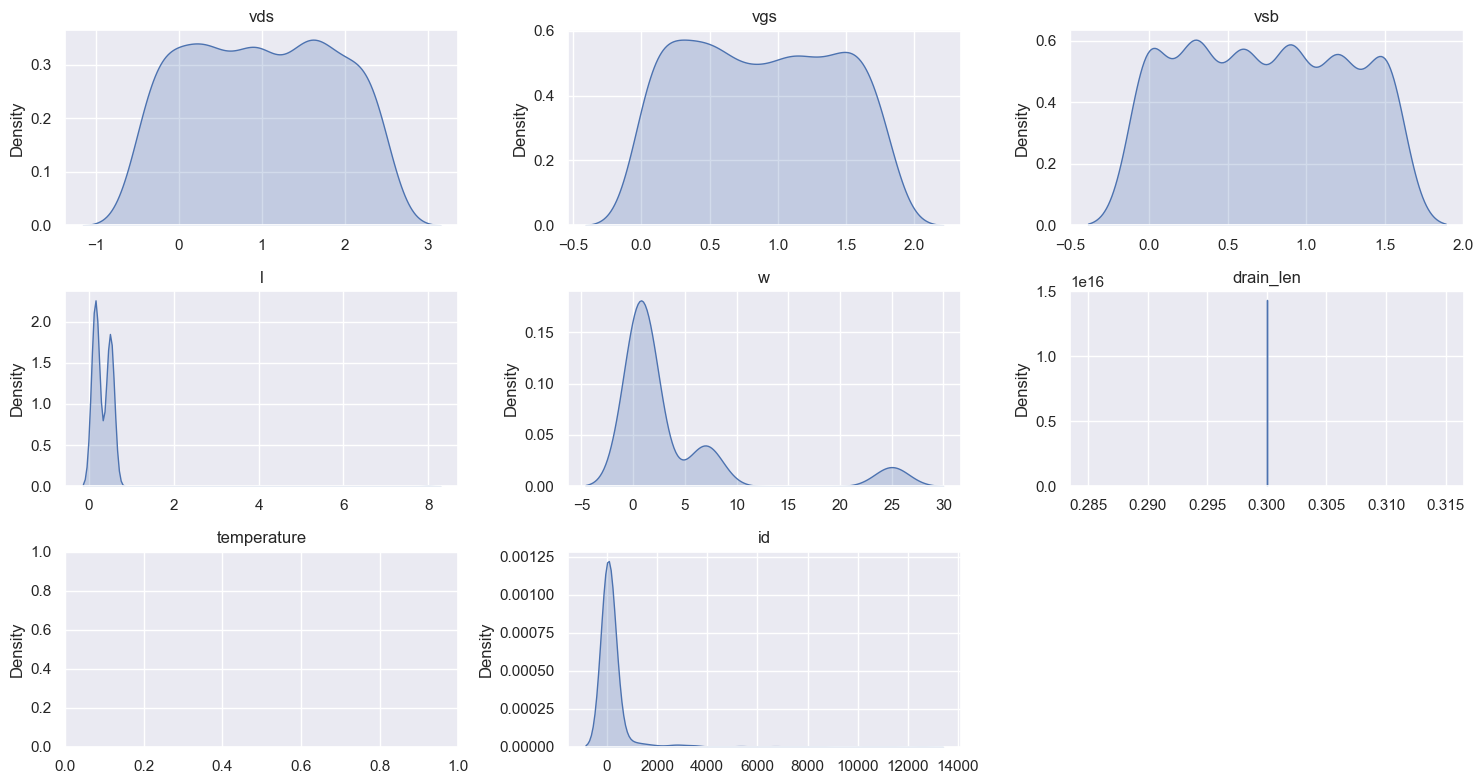

In [58]:
numeric_df = df.select_dtypes(include='number')

plt.figure(figsize=(15, 8))
num_columns = len(numeric_df.columns)

# Creating subplots for each feature's histogram
for i, col in enumerate(numeric_df.columns):
    plt.subplot(3, num_columns // 3 + 1, i + 1)
    sns.kdeplot(numeric_df.sample(1000)[col], shade=True, color='b')
    plt.title(col)
    plt.xlabel("")

plt.tight_layout()

> * **Distribution of the features**
>   - Most of the features exhibit a **Normal Distribution**, suggesting that the data tends to cluster around the mean.
>

> * **Feature Ranges**
>   * The ranges of the features are different. So, we should consdier normalizing them.

> * **Single valued features**
>   * `temperature` & `drain_len` have a single value across the entire dataset, which suggests they may lack discriminatory power for modeling. Consider their relevance for inclusion in the analysis.

> * **Outliers in 'w' Feature**:
>   * Notably, the 'w' feature contains outliers. These values deviate significantly from the majority of data points and may require special consideration in data preprocessing and modeling.

In [68]:
Q1 = df.w.quantile(0.25)
Q3 = df.w.quantile(0.75)
IQR = Q3 - Q1

threshold = 1.5
# Define the lower and upper bounds for outliers
lower_bound = Q1 - threshold * IQR
upper_bound = Q3 + threshold * IQR

df_with_w_outliers_only = df.query(f'w < {lower_bound} or w > {upper_bound}')
print(f'There are {df_with_w_outliers_only.shape[0]} readings that have width considered outlier!')

There are 205123 readings that have width considered outlier!


#### Considering categorical feature `corner`

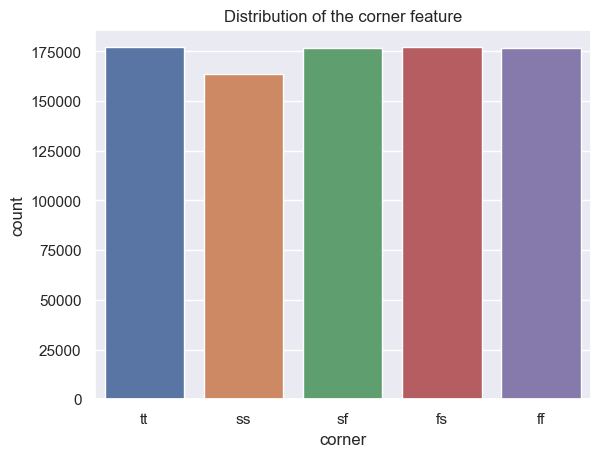

In [179]:
sns.countplot(data=df, x='corner');
plt.title('Distribution of the corner feature');

> * They are distibuted slightly equally on the dataset. 
>
> * As they are just 5 unique features, we could One Hot Encoding them.

### Data Cleaning

> First lets drop the single values features

In [76]:
df.drop(columns=['temperature', 'drain_len'], inplace=True)

> We will make some transformation on the data such as, standarizing it and converting the categorical values into numerical values `in the modeling phase after the EDA.`

---

## Exploratory Data Analysis (EDA)

> In this exploratory data analysis phase, we will strive to answer several important questions that will\
aid our understanding of the dataset and inform our modeling process.

> **The questions we aim to address are as follows:**
> 1. How does the average current ('id') change with varying width 'w' and length 'l'?
> 2. How does the average current ('id') change with varying width ('vgs'), back-gate voltage ('vsb'), and drain-source voltage ('vds')?
> 3. What is the relationship between average current ('id') and the categorical feature 'corner'?
> 4. Which features are the best predictors for the current value?

> **Splitting the data into train & test.**
> 
> The data was split into training and testing sets before EDA to ensure complete test set independence and facilitate parameter tuning without any test set insights.

In [160]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=SEED)
df_train.head(2)

,vds,vgs,vsb,l,w,corner,id
801381,1.35,0.1,1.5,0.5,0.65,ff,8.561236e-10
770725,-0.45,0.9,0.9,0.5,0.36,ff,3.424492e+01


#### Q1) How does the average current ('id') change with varying width 'w' and length 'l'?

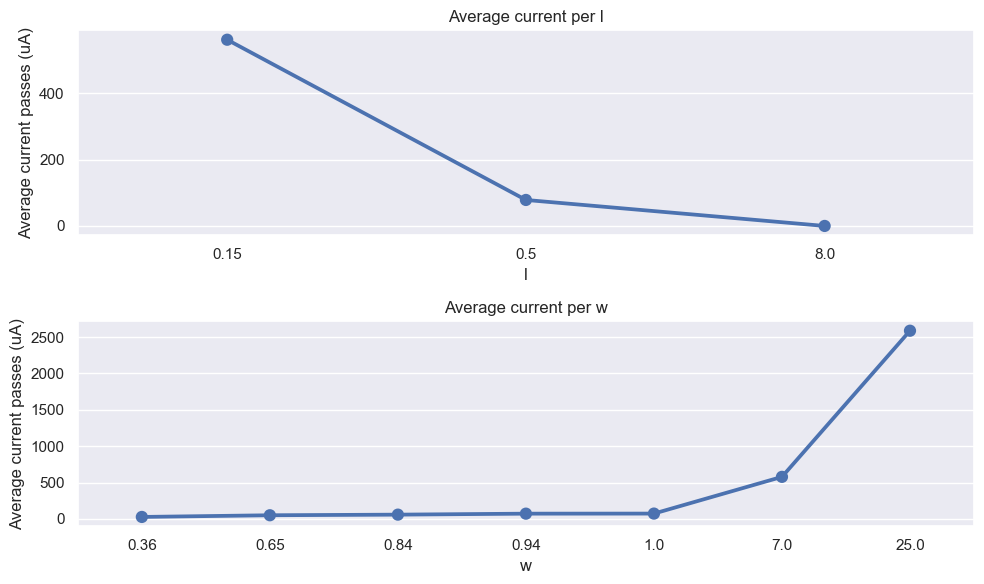

In [322]:
mean_id_by_column(df_train, ['l', 'w'])

> * **Length (l):**
>   * Increasing the length (L) results in a decrease in the average current passing through the transistor.
>   * When the length is 0.8 µm, the current drops to zero.
> * **Width (w):**
>   * For widths less than 1 µm, no current passes through the transistor.
>   * Once the width exceeds 1 µm, the average current starts to increase.

#### Q2) How does the average current ('id') change with varying width vgs, vsb, and the vds?

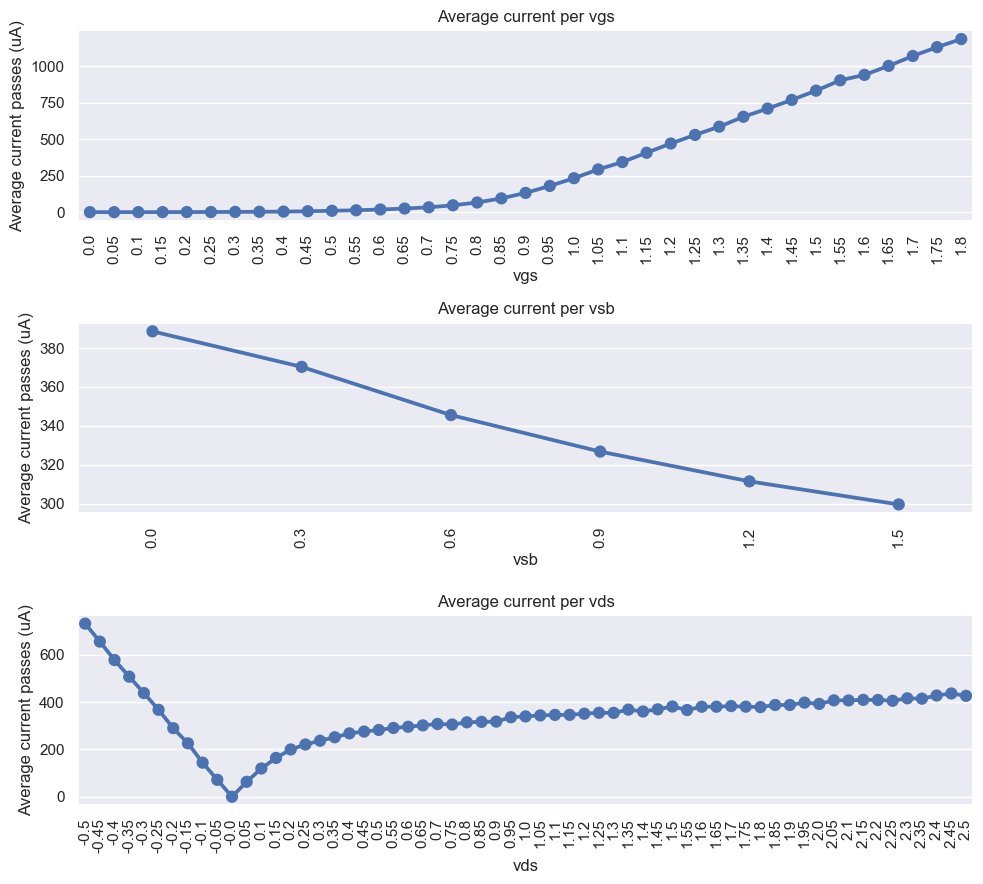

In [325]:
mean_id_by_column(df_train, ['vgs', 'vsb', 'vds'], x_rotation=90)

> * **Gate-Source Voltage ('vgs'):**
>   * For 'vgs' values below 0.7, 'id' remains close to 0. This voltage threshold (Vth) indicates that the transistor does not conduct current until a certain gate-source voltage is applied.
>   * The current remains at 0 until 'vgs' reaches 0.7, after which it starts to exhibit either a linear or exponential behavior.
> * **Source-Body Voltage ('vsb'):**
>   * An increase in 'vsb' results in a decrease in the average current passing through the transistor.
> * **Drain-Source Voltage ('vds'):**
>   * For negative values of 'vds', the current exhibits a linear decrease. It eventually reaches zero current at 'vds' equals 0 and then begins to increase logarithmically.  

#### Q3) What is the relationship between average current ('id') and the categorical feature 'corner'?

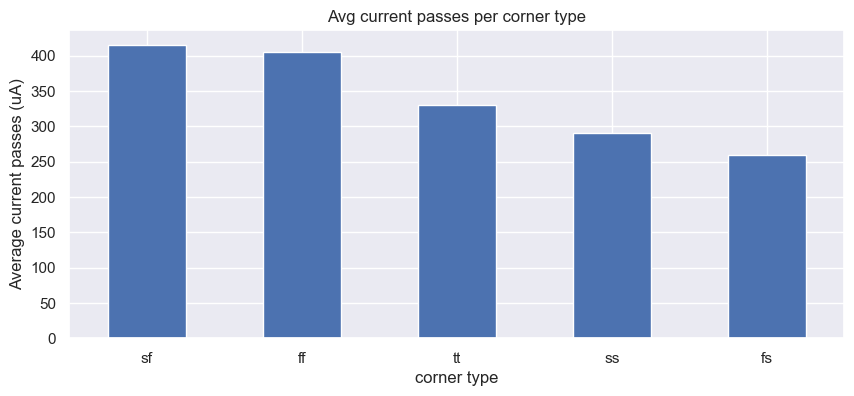

In [176]:
plt.figure(figsize=(10, 4))
df_train.groupby('corner').mean().id.sort_values(ascending=False).plot(kind='bar');
plt.title('Avg current passes per corner type');
plt.xlabel('corner type');
plt.ylabel('Average current passes (uA)');
plt.xticks(rotation=0);

> Notably, the 'corner' category `sf` demonstrates the highest mean 'id' value at `415.105`, indicating that this\
corner type tends to result in the highest transistor current on average. Conversely, the 'corner' category `fs` has the lowest mean 'id' value at `259.326`, suggesting a lower average transistor current.

#### Q4) Which features are the best predictors for the current value?

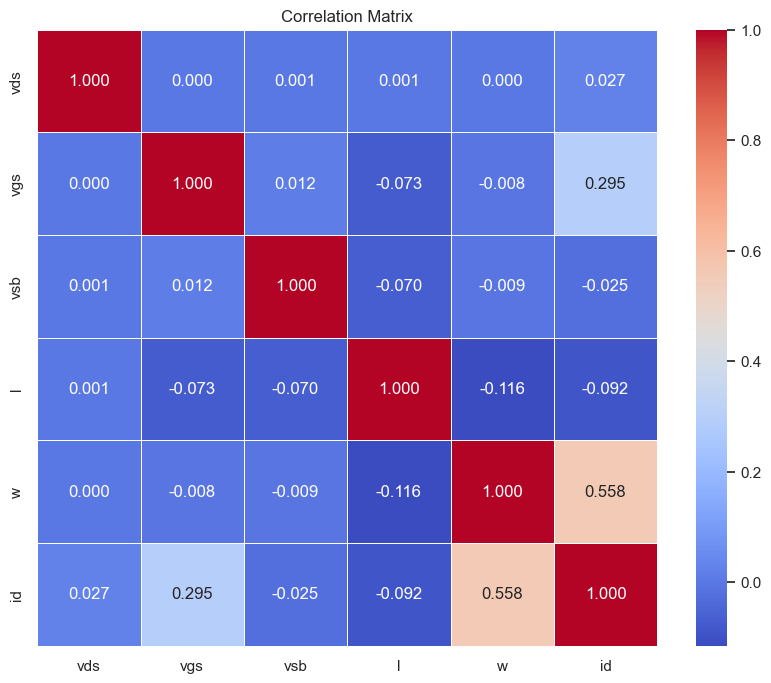

In [338]:
plt.figure(figsize=(10, 8))

correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f");
plt.title('Correlation Matrix');

> * There are just 2 features with a slightly significant relation ot the Id.
>   * `width (w)` & `vgs`

> But we could consider some **Feature Engineering** to make more informative features, such as `making compinations of features`
> * width / lenght.
> * Vgs - Vds
> * Vgs * Vds

In [339]:
df_train = add_compination_of_features(df_train)
df_test  = add_compination_of_features(df_test)

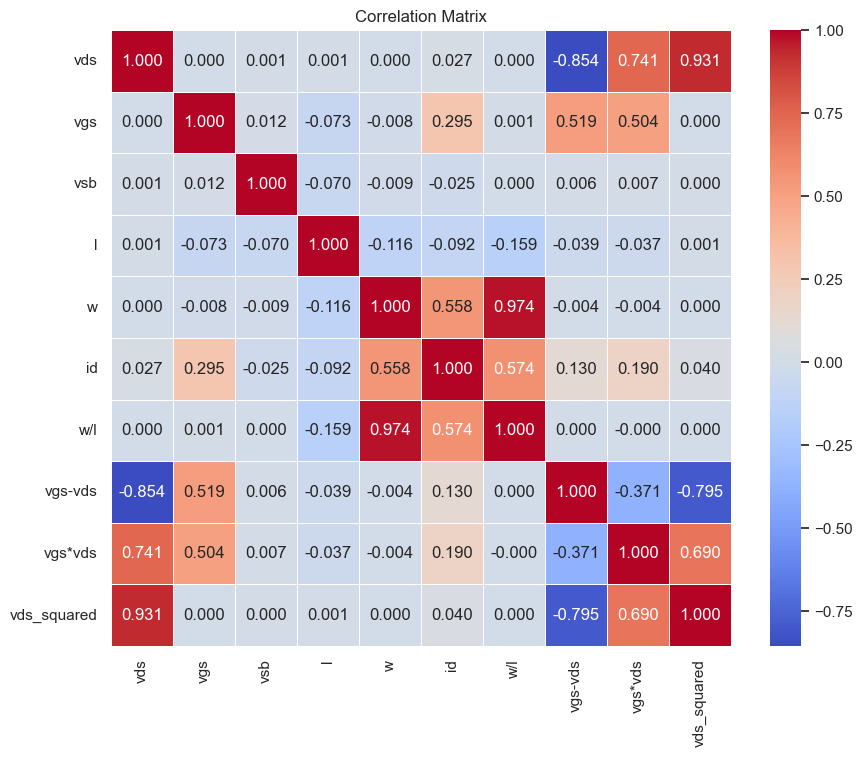

In [341]:
plt.figure(figsize=(10, 8))

correlation_matrix = df_train.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, fmt=".3f");
plt.title('Correlation Matrix');

> We could see that there is slightly related features to the Id added.

> Converting the categorical feature `corner` to numeric values.

In [382]:
df_train = pd.get_dummies(df_train, columns=['corner'], drop_first=True)
df_test = pd.get_dummies(df_test, columns=['corner'], drop_first=True)

> Getting feature importance from the Random Forests algorithm.

In [389]:
from sklearn.ensemble import RandomForestRegressor
feature_importance_model = RandomForestRegressor(n_estimators=100, random_state=SEED, n_jobs=-1, verbose=2)
feature_importance_model.fit(X=df_train.drop(columns=['id']), y=df_train.id)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.


building tree 1 of 100
building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100


[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:  1.0min


building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65 of 100
building tree 66 of 100
building tree 67 of 100
building tree 68 of 100
building tree 69 of 100
building tree 70 of 100
building tree 71

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.3min finished


RandomForestRegressor(n_jobs=-1, random_state=1234, verbose=2)

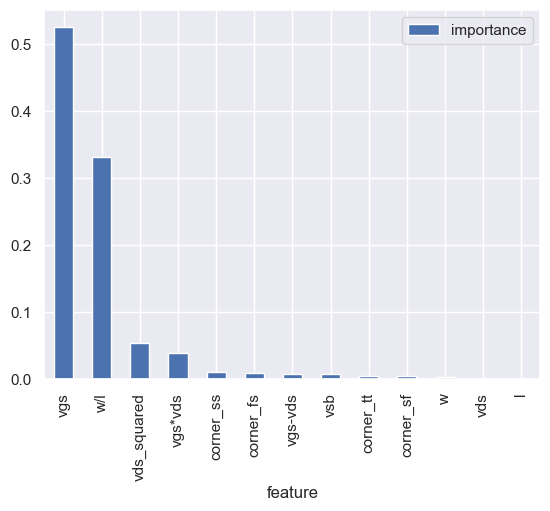

In [390]:
feature_importance = feature_importance_model.feature_importances_
dd = pd.DataFrame({'feature': df_train.drop(columns=['id']).columns, 'importance': feature_importance})
dd.sort_values(by='importance', ascending=False).plot(x='feature', y='importance', kind='bar');

## Modeling

In [101]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, make_scorer, confusion_matrix, roc_curve, roc_auc_score, ConfusionMatrixDisplay

### Pipline of preprocessing for modeling

In [377]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

numeric_features = df_train.select_dtypes(include='number').columns[0]
categorical_features = [df_train.select_dtypes(exclude='number').columns[0]]

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(sparse=False), categorical_features)
    ]
)

preprocessor.fit_transform(df_train)

ValueError: 1D data passed to a transformer that expects 2D data. Try to specify the column selection as a list of one item instead of a scalar.